In [1]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from numpy import dot
from numpy.linalg import norm
import glob
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
import pandas as pd

In [2]:
import configparser
import torch
import torchvision.transforms as transforms
import os
import numpy as np

from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True


model_path = r'D:/seegene/noiseFiltering_GPU/model/M4.pkl'

# load model
model = torch.load(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
model.to(device)

os.system('cls')

transformations = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

normal_threshold = 0.9



In [7]:
# making True image file function
def is_noise(image_filename):

    image = Image.open(image_filename)
    result, confidence = model_filtering(image)
    
    return result, confidence


def model_filtering(image):
    x = transformations(image)
    x = x.unsqueeze(0)
    x = x.to(device)

    output = model(x)
    
    pred = torch.argmax(output, 1)

    res = pred.item()
    temp = np.exp(output[0][0].item())
    if res == 0:
  
        if temp > normal_threshold:
            res = 0
        else: res = 1

    return res, temp  # noise = 1; otherwise.

def numbering(filename):
  split_file = filename.split("\\")
  number = split_file[-1]

  if len(number) == 5 : #1.png
    return int('00' + number[0])
  elif len(number)== 6: #12.png
    return int('0' + number[:2])
  elif len(number)== 7: #12.png
    return int( number[:3])

In [8]:
path = r'D:/seegene/data/representative/2021S_0480717010101/*'
file_list = glob.glob(path)
file_list_png = [file for file in file_list if file.endswith(".png")]
image_file = pd.DataFrame(file_list_png, columns = ["filename"])

In [9]:
#True image file

image_file["confidence"] = ""
image_file["noise"] = ""

for i in tqdm(range(len(image_file))):

  result, confidence = is_noise(image_file.filename[i])

  if result == 0:
    image_file['confidence'][i] = confidence
    image_file['noise'][i] = 'No'
  elif result == 1:
    image_file['confidence'][i] = confidence
    image_file['noise'][i] = 'Yes'



image_file['number'] = image_file['filename'].apply(numbering)
True_image_file = image_file[image_file['noise'] == 'No'].sort_values(by=['number']).reset_index(drop=True)
True_image_file

100%|██████████| 602/602 [00:43<00:00, 13.68it/s]


,filename,confidence,noise,number
0,D:/seegene/data/representative/2021S_048071701...,0.979614,No,29
1,D:/seegene/data/representative/2021S_048071701...,0.957493,No,30
2,D:/seegene/data/representative/2021S_048071701...,0.952602,No,51
3,D:/seegene/data/representative/2021S_048071701...,0.978931,No,52
4,D:/seegene/data/representative/2021S_048071701...,0.965045,No,53
...,...,...,...,...
171,D:/seegene/data/representative/2021S_048071701...,0.990945,No,547
172,D:/seegene/data/representative/2021S_048071701...,0.997002,No,548
173,D:/seegene/data/representative/2021S_048071701...,0.988741,No,549
174,D:/seegene/data/representative/2021S_048071701...,0.987099,No,550


In [19]:
True_image_file.filename.tolist()

['D:/seegene/data/representative/2021S_0480717010101\\29.png',
 'D:/seegene/data/representative/2021S_0480717010101\\30.png',
 'D:/seegene/data/representative/2021S_0480717010101\\51.png',
 'D:/seegene/data/representative/2021S_0480717010101\\52.png',
 'D:/seegene/data/representative/2021S_0480717010101\\53.png',
 'D:/seegene/data/representative/2021S_0480717010101\\54.png',
 'D:/seegene/data/representative/2021S_0480717010101\\58.png',
 'D:/seegene/data/representative/2021S_0480717010101\\59.png',
 'D:/seegene/data/representative/2021S_0480717010101\\70.png',
 'D:/seegene/data/representative/2021S_0480717010101\\71.png',
 'D:/seegene/data/representative/2021S_0480717010101\\72.png',
 'D:/seegene/data/representative/2021S_0480717010101\\73.png',
 'D:/seegene/data/representative/2021S_0480717010101\\74.png',
 'D:/seegene/data/representative/2021S_0480717010101\\77.png',
 'D:/seegene/data/representative/2021S_0480717010101\\79.png',
 'D:/seegene/data/representative/2021S_0480717010101\\8

In [22]:
# labeling function

def split_clustering(imageA,imageB,theshold=0.8):
    similarity = cosine_similarity(imageA, imageB)

    if similarity <= theshold:
        differ = 0
    else:
        differ = 1
    return similarity, differ

def trans_array(image):
    Image_open = Image.open(image)
    image_sequence = Image_open.getdata()
    image_array = np.array(image_sequence)/255
    return image_array.reshape(-1)


def cosine_similarity(list_1, list_2):
  cos_sim = dot(list_1, list_2) / (norm(list_1) * norm(list_2))
  return cos_sim

In [24]:
#유사도에 따라서 labeling하기
True_image_file['label']= ""
True_image_file['similarity']= ""

label = 0 

for i in tqdm(range(len(True_image_file)-1)):

  imageA = trans_array(True_image_file['filename'][i])
  imageB = trans_array(True_image_file['filename'][i+1])
  similarity, differ = split_clustering(imageA,imageB,0.975)

  if differ == 0 :
    print(similarity,i)  # 유사도와 유사하지 않는 사진의 index
    label += 1
  True_image_file['label'][i] = label
  True_image_file['similarity'][i] = similarity
  

  0%|          | 0/175 [00:00<?, ?it/s]C:\Users\HONG\AppData\Local\Temp/ipykernel_29216/3057224636.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  True_image_file['label'][i] = label
C:\Users\HONG\AppData\Local\Temp/ipykernel_29216/3057224636.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  True_image_file['similarity'][i] = similarity
  5%|▍         | 8/175 [00:26<09:04,  3.26s/it]

0.9603139166090306 7


  7%|▋         | 13/175 [00:42<08:47,  3.26s/it]

0.9660094246591188 12


  8%|▊         | 14/175 [00:45<08:44,  3.26s/it]

0.9543432999141157 13


  9%|▉         | 16/175 [00:52<08:38,  3.26s/it]

0.9618206244443882 15


 11%|█         | 19/175 [01:01<08:26,  3.25s/it]

0.9630324240535264 18


 11%|█▏        | 20/175 [01:05<08:24,  3.26s/it]

0.9506687730835298 19


 12%|█▏        | 21/175 [01:08<08:21,  3.25s/it]

0.9338368097795439 20


 13%|█▎        | 22/175 [01:11<08:17,  3.25s/it]

0.9723865744857806 21


 20%|██        | 35/175 [01:53<07:35,  3.25s/it]

0.9736719200900773 34


 25%|██▌       | 44/175 [02:23<07:05,  3.24s/it]

0.9649911038457308 43


 29%|██▉       | 51/175 [02:45<06:42,  3.25s/it]

0.9714813472849252 50


 30%|███       | 53/175 [02:52<06:36,  3.25s/it]

0.970958620696193 52


 31%|███▏      | 55/175 [02:59<06:34,  3.29s/it]

0.971262944450285 54


 33%|███▎      | 57/175 [03:05<06:26,  3.27s/it]

0.8237189073411728 56


 34%|███▎      | 59/175 [03:12<06:19,  3.27s/it]

0.9673995895240212 58


 35%|███▍      | 61/175 [03:18<06:13,  3.27s/it]

0.969262765111939 60


 36%|███▌      | 63/175 [03:25<06:05,  3.26s/it]

0.824390872453187 62


 45%|████▌     | 79/175 [04:16<05:10,  3.24s/it]

0.9491967050343149 78


 46%|████▌     | 80/175 [04:20<05:06,  3.23s/it]

0.9374253699752811 79


 46%|████▋     | 81/175 [04:23<05:03,  3.23s/it]

0.9618138210137871 80


 47%|████▋     | 83/175 [04:29<04:58,  3.24s/it]

0.9370910744338662 82


 49%|████▊     | 85/175 [04:36<04:54,  3.27s/it]

0.9505339159675177 84


 60%|██████    | 105/175 [05:43<03:56,  3.38s/it]

0.9567090808751046 104


 61%|██████    | 106/175 [05:46<03:52,  3.38s/it]

0.9551495413155426 105


 61%|██████    | 107/175 [05:50<03:49,  3.37s/it]

0.9657820323159687 106


 64%|██████▍   | 112/175 [06:07<03:30,  3.35s/it]

0.8152980202353423 111


 65%|██████▍   | 113/175 [06:10<03:27,  3.35s/it]

0.969476594944088 112


 65%|██████▌   | 114/175 [06:13<03:25,  3.37s/it]

0.9722189480373191 113


 66%|██████▌   | 115/175 [06:17<03:23,  3.39s/it]

0.9737843153844696 114


 67%|██████▋   | 118/175 [06:27<03:11,  3.36s/it]

0.8433602417832599 117


 74%|███████▎  | 129/175 [07:04<02:34,  3.35s/it]

0.9486725751462464 128


 75%|███████▍  | 131/175 [07:11<02:27,  3.36s/it]

0.9467010571619625 130


 78%|███████▊  | 137/175 [07:31<02:06,  3.34s/it]

0.9615562445358371 136


 79%|███████▉  | 138/175 [07:34<02:02,  3.32s/it]

0.9632125086918528 137


 84%|████████▍ | 147/175 [08:06<01:36,  3.44s/it]

0.9564333388215122 146


 85%|████████▌ | 149/175 [08:13<01:30,  3.47s/it]

0.9437100527556975 148


 90%|████████▉ | 157/175 [08:40<01:00,  3.37s/it]

0.9501268603635847 156


 90%|█████████ | 158/175 [08:44<00:58,  3.43s/it]

0.9648015148711089 157


 91%|█████████ | 159/175 [08:47<00:55,  3.44s/it]

0.9726776590001228 158


 91%|█████████▏| 160/175 [08:51<00:51,  3.44s/it]

0.9643110015981804 159


 95%|█████████▌| 167/175 [09:14<00:26,  3.37s/it]

0.9731468324529111 166


100%|██████████| 175/175 [09:41<00:00,  3.32s/it]


In [25]:
# select image 
from collections import Counter

def select_image(min_count):
  repersentation_image=[]
  original_index=[]
  counter = Counter(True_image_file['label'])

  for label in counter:
    sub_image_file = True_image_file[True_image_file['label'] == label]
    if counter[label] >= min_count:
      index = sub_image_file.index[np.argmax(sub_image_file["confidence"].tolist())]
      repersentation_image.append(True_image_file['filename'][index])
      original_index.append(index)

  return repersentation_image, original_index

In [26]:
# 최소 4개 이상의 사진을 가진 클러스터만 사용하기
select_image(4)

(['D:/seegene/data/representative/2021S_0480717010101\\29.png',
  'D:/seegene/data/representative/2021S_0480717010101\\59.png',
  'D:/seegene/data/representative/2021S_0480717010101\\103.png',
  'D:/seegene/data/representative/2021S_0480717010101\\115.png',
  'D:/seegene/data/representative/2021S_0480717010101\\133.png',
  'D:/seegene/data/representative/2021S_0480717010101\\262.png',
  'D:/seegene/data/representative/2021S_0480717010101\\294.png',
  'D:/seegene/data/representative/2021S_0480717010101\\336.png',
  'D:/seegene/data/representative/2021S_0480717010101\\431.png',
  'D:/seegene/data/representative/2021S_0480717010101\\446.png',
  'D:/seegene/data/representative/2021S_0480717010101\\473.png',
  'D:/seegene/data/representative/2021S_0480717010101\\496.png',
  'D:/seegene/data/representative/2021S_0480717010101\\534.png',
  'D:/seegene/data/representative/2021S_0480717010101\\536.png'],
 [0, 7, 22, 34, 49, 77, 84, 106, 123, 132, 145, 149, 164, 166])

In [27]:
# checking image function 

def show_image(index, size, con):
    sizes = size, size
    width = 0

    dst = Image.new('RGB', (size*(2*con+1), 224))
    for i in range(index-con, index+con+1): 
      im = Image.open(True_image_file['filename'][i])
      im.thumbnail(sizes)
      dst.paste(im, (width, 0))
      width += size
      
      print(True_image_file['similarity'][i])

    return dst

0.9486725751462464
0.9927699441880337
0.9467010571619625
0.9948756126962184
0.9954799163308128


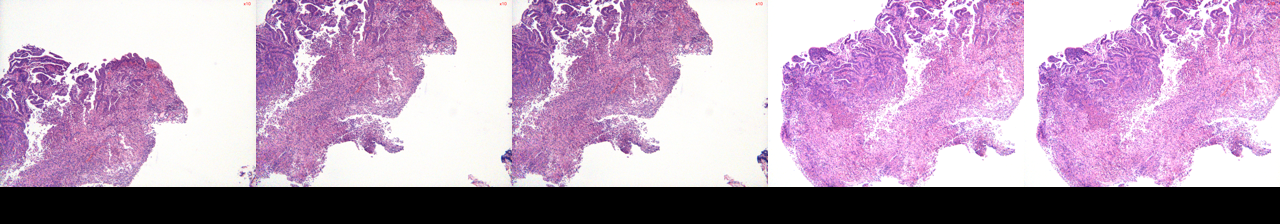

In [28]:
# 130번 index를 256 size로 보여주고, 양옆으로 2개의 사진을 비교하기
show_image(130,256,2)

0.9906958417036424
0.9981515709314848
0.9603139166090306
0.9980214519129357
0.9978531455306066


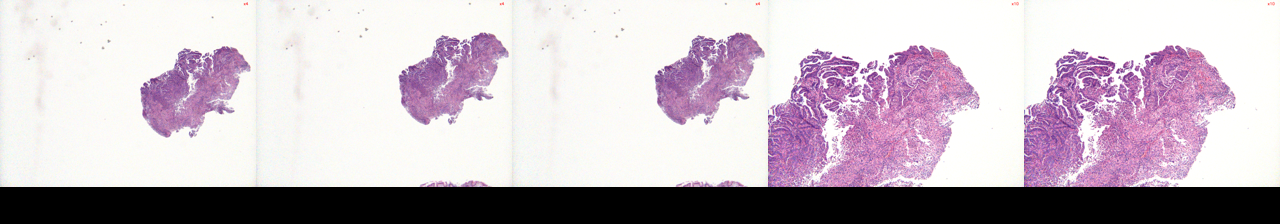

In [29]:
show_image(7,256,2)

In [ ]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Created Directory : ", dir)
    else:
        print("Directory already existed : ", dir)


def show_top_k(k):
    '''
    True_image_file에서
    label top k개 선별 후
    각 클러스터에서 컨피던스 제일 높은 사진 총 k장 뽑고
    그걸 지정된 dir/k/라는 폴더에 저장
    '''